In [ ]:
import matplotlib.pyplot as plt
from google.colab import drive
import pandas as pd
from io import StringIO
from math import sqrt
import numpy as np
import scipy.stats as st
from scipy.fftpack import fft, fftfreq
from scipy.signal import argrelextrema
import operator
import os
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from time import time
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit


drive.mount('/content/drive')

Mounted at /content/drive


Xác định peak: đỉnh có norm2 cao nhất

--> xác định vùng tín hiệu chứa hành động.

In [ ]:
def euclidean_norm(x, y, z):
  return sqrt(x**2 + y**2 + z**2)

def find_max_norm_index(df):
    max_norm_index = df.apply(lambda row: euclidean_norm(abs(row['acc_x']) + row['gyro_x'], abs(row['acc_y']) + row['gyro_y'], abs(row['acc_z']) + row['gyro_z']), axis=1).idxmax()
    time = df.loc[max_norm_index, 'time']
    return max_norm_index, time

def selected_signals_range(df, reference_time):
  return df[abs(df.index - reference_time) <= 500]


Đọc file ứng với file_path trong drive + tìm index của peak

In [ ]:
def read_file(file_path):
    try:
        with open(file_path, 'r', encoding='latin-1') as file:
            file_content = file.read()

        # Define the new column names
        new_headers = ["time", "acc_x", "acc_y", "acc_z", "gyro_x", "gyro_y", "gyro_z"]

        df = pd.read_csv(StringIO(file_content), header=None, sep=';', names=new_headers, engine='python', skiprows=1)
        df['time'] = df['time'] - df.at[0, 'time']

        index, time = find_max_norm_index(df)
        return df, index, time

    except UnicodeDecodeError as e:
        print(f"Error decoding file {file_path}: {e}")

Trích xuất đặc trưng thống kê của tín hiệu trên miền thời gian

In [ ]:
# Parameter: data series
def stat_features(ds):
  if ds.empty:
    raise ValueError("Input series is empty.")
  ds = np.array(ds).flatten()
  mean_ft = np.mean(ds).reshape(-1,1)           # mean
  min_ft = np.amin(ds).reshape(-1,1)            # min
  max_ft = np.amax(ds).reshape(-1,1)            # max
  range_ft = np.ptp(ds).reshape(-1,1)           # range (peak-to-peak)
  std_ft = np.std(ds).reshape(-1,1)             # standard deviation
  var_ft = np.var(ds).reshape(-1,1)             # variance
  skew_ft = st.skew(ds).reshape(-1,1)           # skewness
  kurtosis_ft = st.kurtosis(ds).reshape(-1,1)   # kurtosis
  iqr_ft = st.iqr(ds).reshape(-1,1)             # interquartile rante
  mad_ft = np.median(np.sort(abs(ds - np.median(ds)))).reshape(-1,1) # median absolute deviation

  return np.concatenate((mean_ft, min_ft, max_ft, range_ft, std_ft, var_ft, skew_ft, kurtosis_ft, iqr_ft, mad_ft), axis=1).flatten()


Tạo vector đặc trưng cho mỗi sample

In [ ]:
def make_feature_vector(data, Te=1.0):
  if data.empty:
    raise ValueError("Input series is empty.")
  acc_re = np.sqrt(data['acc_x']**2 + data['acc_y']**2 + data['acc_z']**2)
  gyro_re = np.sqrt(data['gyro_x']**2 + data['gyro_y']**2 + data['gyro_z']**2)

  # Raw signals
  features_acc_x = stat_features(data['acc_x'])
  features_acc_y = stat_features(data['acc_y'])
  features_acc_z = stat_features(data['acc_z'])
  features_acc_re = stat_features(acc_re)
  features_gyro_x = stat_features(data['gyro_x'])
  features_gyro_y = stat_features(data['gyro_y'])
  features_gyro_z = stat_features(data['gyro_z'])
  features_gyro_re = stat_features(gyro_re)

  # Jerk signals
  features_acc_x_jerk = stat_features(data['acc_x'].diff().dropna())
  features_acc_y_jerk = stat_features(data['acc_y'].diff().dropna())
  features_acc_z_jerk = stat_features(data['acc_z'].diff().dropna())
  features_acc_re_jerk = stat_features(acc_re.diff().dropna())
  features_gyro_x_jerk = stat_features(data['gyro_x'].diff().dropna())
  features_gyro_y_jerk = stat_features(data['gyro_y'].diff().dropna())
  features_gyro_z_jerk = stat_features(data['gyro_z'].diff().dropna())
  features_gyro_re_jerk = stat_features(gyro_re.diff().dropna())

  return np.concatenate((features_acc_x, features_acc_y, features_acc_z, features_acc_re,
                         features_gyro_x, features_gyro_y, features_gyro_z, features_gyro_re,
                         features_acc_x_jerk, features_acc_y_jerk, features_acc_z_jerk, features_acc_re_jerk,
                         features_gyro_x_jerk, features_gyro_y_jerk, features_gyro_z_jerk, features_gyro_re_jerk), axis=0)

Đọc tất cả các dữ liệu và trích xuất đặc trưng

In [ ]:
def read_data(folder_path):
  feature_vectors = []
  label = 1 if folder_path.endswith('Falling') else -1
  # Duyệt qua tất cả các thư mục và file trong thư mục gốc
  for root, dirs, files in os.walk(folder_path):
      for file in files:
        try:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                df, index, time = read_file(file_path)
                df.set_index('time', inplace=True)
                feature_vector = make_feature_vector(selected_signals_range(df, time))
                feature_vectors.append(np.append(feature_vector, label))
                print(f"Processed file: {file_path}")
        except ValueError as error:
            print(f"Error processing file {file_path}: {error}")

  feature_matrix = np.vstack(feature_vectors)
  return feature_matrix

fvs_falling = read_data('/content/drive/MyDrive/FallDetectionAI/TestDataset/Falling')
fvs_adl = read_data('/content/drive/MyDrive/FallDetectionAI/TestDataset/ADL')
fvs = np.concatenate((fvs_falling, fvs_adl), axis=0)
print(fvs)

Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P15_04.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P15_05.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P15_03.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P15_01.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P15_10.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P15_09.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P15_06.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P13_05.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P14_10.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P14_04.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/Falling/F03/P15_07.txt
Processed 

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL01/P13_07.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL01/P13_02.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL01/P13_10.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL07/P13_05.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL07/P13_01.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL07/P13_09.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL07/P13_07.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL07/P13_10.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL07/P13_02.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL07/P13_03.txt
Processed file: /content/drive/MyDrive/FallDetectionAI/TestDataset/ADL/ADL07/P13_08.txt
Processed file: /content/drive/M

Header của feature vector

In [ ]:
def header_stat(feature, type):
  end = '_' + feature + '_' + type
  base_headers = ['mean', 'min', 'max', 'range', 'std', 'var', 'skew', 'kurtosis', 'iqr', 'mad']
  headers = [header + end for header in base_headers]
  return headers

headers = np.concatenate((header_stat('acc_x', 'raw'), header_stat('acc_y', 'raw'), header_stat('acc_z', 'raw'), header_stat('acc_re', 'raw'),
                          header_stat('gyro_x', 'raw'), header_stat('gyro_y', 'raw'), header_stat('gyro_z', 'raw'), header_stat('gyro_re', 'raw'),
                          header_stat('acc_x', 'jerk'), header_stat('acc_y', 'jerk'), header_stat('acc_z', 'jerk'), header_stat('acc_re', 'jerk'),
                          header_stat('gyro_x', 'jerk'), header_stat('gyro_y', 'jerk'), header_stat('gyro_z', 'jerk'), header_stat('gyro_re', 'jerk'),
                          ['fall_adl_bin']), axis=0)

print(len(headers))

161


**** Chuyển các vector đặc trưng đã lấy được thành file csv (dùng lần đầu)

In [ ]:
df = pd.DataFrame(fvs, columns=headers)
df.to_csv('/content/drive/MyDrive/FallDetectionAI/TestDataset/dataset_raw.csv', index=False)

**** Lấy vector đặc trưng từ file dataset.csv, chọn các đặc trưng quan trọng --> lưu vào file dataset_extract.csv (dùng lần đầu)

In [1]:
df = pd.read_csv('/content/drive/MyDrive/FallDetectionAI/TestDataset/dataset_raw.csv')
print(df)
new_df = df[['max_acc_re_raw', 'std_acc_re_raw', 'var_acc_re_raw', 'iqr_acc_re_raw', 'mad_acc_re_raw', 'max_acc_re_jerk', 'min_acc_re_jerk', 'range_acc_re_jerk', 'std_acc_re_jerk', 'var_acc_re_jerk', 'mad_acc_re_jerk', 'max_gyro_re_raw', 'std_gyro_re_raw', 'var_gyro_re_raw', 'iqr_gyro_re_raw', 'mad_gyro_re_raw', 'max_gyro_re_jerk', 'min_gyro_re_jerk', 'range_gyro_re_jerk', 'std_gyro_re_jerk', 'var_gyro_re_jerk', 'mad_gyro_re_jerk', 'fall_adl_bin']]
new_df.to_csv('/content/drive/MyDrive/FallDetectionAI/TestDataset/dataset_extract.csv')

NameError: name 'pd' is not defined

Lấy vector đặc trưng các mẫu từ file dataset_extract.csv

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/FallDetectionAI/Dataset/dataset_extract.csv')
X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]
print(X)
print(y)

     max_acc_re_raw  std_acc_re_raw  var_acc_re_raw  iqr_acc_re_raw  \
0         79.426813       14.395824      207.239745        5.279334   
1         79.942050       12.848112      165.073984        6.109340   
2         43.709864        7.690935       59.150487        8.359563   
3         76.346697       13.702417      187.756232       12.470848   
4         61.273160        9.860816       97.235696        8.587735   
..              ...             ...             ...             ...   
964       10.991944        1.057696        1.118722        1.065632   
965       10.976701        1.836137        3.371399        1.733712   
966       10.202623        0.642235        0.412466        0.875620   
967       11.723485        0.828089        0.685732        1.167731   
968       12.051688        0.877458        0.769933        0.904160   

     mad_acc_re_raw  max_acc_re_jerk  min_acc_re_jerk  range_acc_re_jerk  \
0          2.468333        27.863420       -33.730666          61.59408

Chia dataset thành 3 tập: traitraining set, validation set, testing set (6 - 2 - 2)

In [ ]:
splitter1 = StratifiedShuffleSplit(n_splits=1, train_size=0.8, test_size=0.2, random_state=12)

for train_index, val_index in splitter1.split(X, y):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

# splitter2 = StratifiedShuffleSplit(n_splits=1, train_size=0.75, test_size=0.25, random_state=12)

# for train_index, val_index in splitter2.split(X_train_val, y_train_val):
#   X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
#   y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]


*Thống kê phân bố mẫu ở mỗi tập*

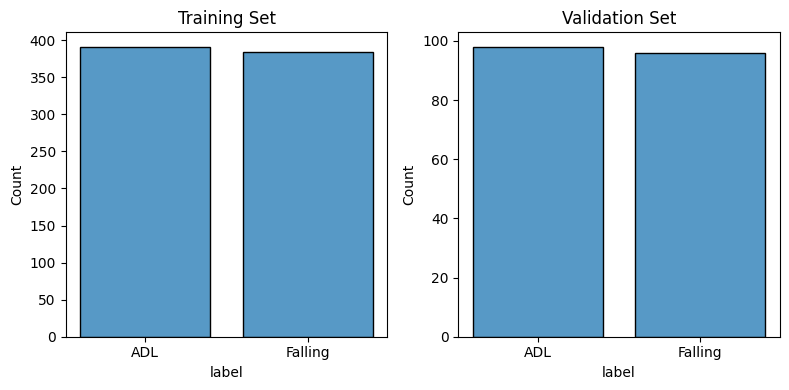

In [ ]:
# Tạo DataFrame từ Series để dễ xử lý
df_train = pd.DataFrame({'label': y_train})
df_val = pd.DataFrame({'label': y_val})

# Thay đổi nhãn
df_train['label'] = df_train['label'].replace({-1: 'ADL', 1: 'Falling'})
df_val['label'] = df_val['label'].replace({-1: 'ADL', 1: 'Falling'})

# Sắp xếp lại cột theo thứ tự ADL trước, Falling sau
df_train['label'] = pd.Categorical(df_train['label'], categories=['ADL', 'Falling'], ordered=True)
df_val['label'] = pd.Categorical(df_val['label'], categories=['ADL', 'Falling'], ordered=True)

# Vẽ histogram sử dụng seaborn
plt.figure(figsize=(8, 4))

# Tập huấn luyện
plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='label', discrete=True, shrink=0.8)
plt.title('Training Set')

# Tập validation
plt.subplot(1, 2, 2)
sns.histplot(data=df_val, x='label', discrete=True, shrink=0.8)
plt.title('Validation Set')

plt.tight_layout()
plt.show()


Scale về phân phối chuẩn (sử dụng scaler từ X_train là để đảm bảo rằng quá trình huấn luyện của mô hình không bị ảnh hưởng bởi thông tin từ tập validation hoặc tập test -> nếu bị rò rỉ sẽ ảnh hưởng tới hiệu suất mô hình)

In [ ]:
# Scale dữ liệu trên tập huấn luyện
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)

# Scale dữ liệu trên tập validation
X_val_scaled = scaler.transform(X_val)


**Xuất ma trận nhầm lẫn (confusion matrix)**

In [ ]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     ha="center", va="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Hàm SVM dùng linear kernel (xem như không dùng kernel func) với tham số C (sử dụng phương pháp đánh giá Hold-out)

In [ ]:
def SVM_Linear_Kernel(X_train, y_train, X_val, y_val, C, draw_confusion_matrix=False):
    linear_svm = LinearSVC(C=C, max_iter=1000000000)

    linear_svm.fit(X_train, y_train)

    y_pred_train = linear_svm.predict(X_train)
    y_pred_val = linear_svm.predict(X_val)

    # Report
    label_names = ['ADL', 'Falling']
    train_report = classification_report(y_train, y_pred_train, target_names=label_names, output_dict=True)
    val_report = classification_report(y_val, y_pred_val, target_names=label_names, output_dict=True)

    if draw_confusion_matrix:
        # Report
        print('Training set report')
        print(classification_report(y_train, y_pred_train, target_names=label_names))
        print('Validation set report')
        print(classification_report(y_val, y_pred_val, target_names=label_names))

        # Plotting
        plt.figure(figsize=(10, 5))

        plt.subplot(1, 2, 1)
        plot_confusion_matrix(y_train, y_pred_train, label_names, title='Training Set Confusion Matrix')
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(y_val, y_pred_val, label_names, title='Validation Set Confusion Matrix')

    return train_report, val_report


Khảo sát mô hình với tham số C và Linear kernel (sử dụng phương pháp đánh giá Hold-out), metrics recall và precision trung bình 2 tập

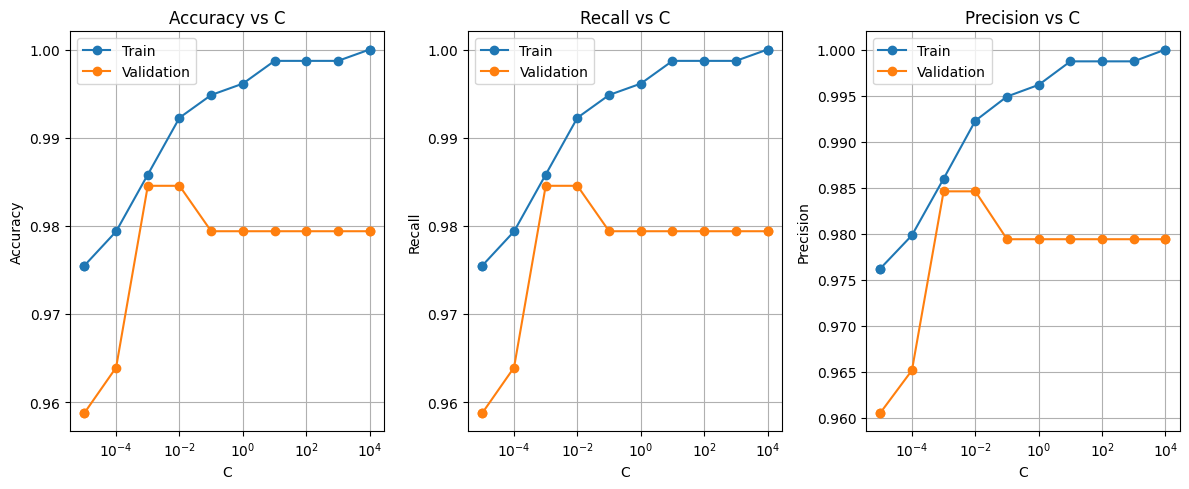

In [ ]:
param_range = np.array([0.00001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 10000])

# List lưu trữ các điểm số
train_accuracies = []
val_accuracies = []

train_recalls = []
val_recalls = []

train_precisions = []
val_precisions = []

# Lặp qua các giá trị của tham số C
for C in param_range:
    train_report, val_report = SVM_Linear_Kernel(X_train, y_train, X_val, y_val, C)

    # Lấy các giá trị accuracy, recall và precision từ báo cáo
    train_accuracy = train_report['accuracy']
    val_accuracy = val_report['accuracy']

    train_recall = train_report['weighted avg']['recall']
    val_recall = val_report['weighted avg']['recall']

    train_precision = train_report['weighted avg']['precision']
    val_precision = val_report['weighted avg']['precision']

    # Lưu các giá trị vào list
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    train_recalls.append(train_recall)
    val_recalls.append(val_recall)

    train_precisions.append(train_precision)
    val_precisions.append(val_precision)

# Vẽ đồ thị
plt.figure(figsize=(12, 5))  # Điều chỉnh kích thước của hình

# Accuracy subplot
plt.subplot(1, 3, 1)  # Sử dụng 1 hàng và 3 cột, và chọn vị trí của subplot là 1
plt.plot(param_range, train_accuracies, marker='o', label='Train')
plt.plot(param_range, val_accuracies, marker='o', label='Validation')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C')
plt.legend()
plt.grid(True)

# Recall subplot
plt.subplot(1, 3, 2)  # Vị trí của subplot là 2
plt.plot(param_range, train_recalls, marker='o', label='Train')
plt.plot(param_range, val_recalls, marker='o', label='Validation')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Recall')
plt.title('Recall vs C')
plt.legend()
plt.grid(True)

# Precision subplot
plt.subplot(1, 3, 3)  # Vị trí của subplot là 3
plt.plot(param_range, train_precisions, marker='o', label='Train')
plt.plot(param_range, val_precisions, marker='o', label='Validation')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Precision')
plt.title('Precision vs C')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Khảo sát mô hình với tham số C và Linear kernel (sử dụng phương pháp đánh giá Hold-out), metrics recall và precision tập Falling

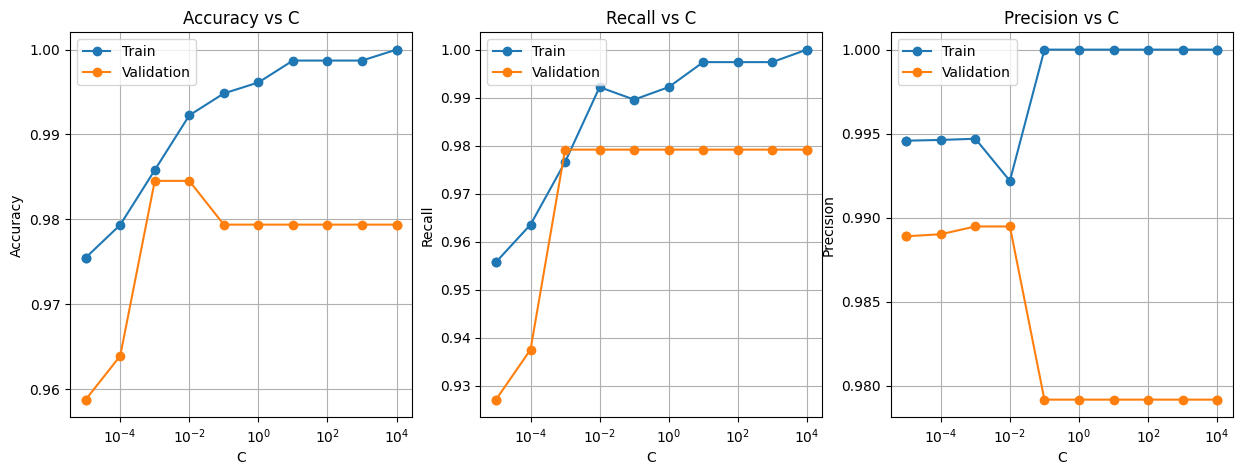

In [ ]:
param_range = np.array([0.00001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 10000])

# List lưu trữ các điểm số
train_accuracies = []
val_accuracies = []
test_accuracies = []

train_recalls = []
val_recalls = []
test_recalls = []

train_precisions = []
val_precisions = []
test_precisions = []

# Lặp qua các giá trị của tham số C
for C in param_range:
    train_report, val_report = SVM_Linear_Kernel(X_train, y_train, X_val, y_val,C)

    # Lấy các giá trị accuracy, recall và precision từ báo cáo
    train_accuracy = train_report['accuracy']
    val_accuracy = val_report['accuracy']


    train_recall = train_report['Falling']['recall']
    val_recall = val_report['Falling']['recall']


    train_precision = train_report['Falling']['precision']
    val_precision = val_report['Falling']['precision']



    # Lưu các giá trị vào list
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)


    train_recalls.append(train_recall)
    val_recalls.append(val_recall)

    train_precisions.append(train_precision)
    val_precisions.append(val_precision)


# Vẽ đồ thị
plt.figure(figsize=(15, 5))  # Sử dụng figsize để điều chỉnh kích thước của hình

# Accuracy subplot
plt.subplot(1, 3, 1)  # Sử dụng 1 hàng và 3 cột, và chọn vị trí của subplot là 1
plt.plot(param_range, train_accuracies, marker='o', label='Train')
plt.plot(param_range, val_accuracies, marker='o', label='Validation')
# plt.plot(param_range, test_accuracies, marker='o', label='Test')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('Accuracy vs C')
plt.legend()
plt.grid(True)

# Recall subplot
plt.subplot(1, 3, 2)  # Vị trí của subplot là 2
plt.plot(param_range, train_recalls, marker='o', label='Train')
plt.plot(param_range, val_recalls, marker='o', label='Validation')
# plt.plot(param_range, test_recalls, marker='o', label='Test')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Recall')
plt.title('Recall vs C')
plt.legend()
plt.grid(True)

# Precision subplot
plt.subplot(1, 3, 3)  # Vị trí của subplot là 3
plt.plot(param_range, train_precisions, marker='o', label='Train')
plt.plot(param_range, val_precisions, marker='o', label='Validation')
# plt.plot(param_range, test_precisions, marker='o', label='Test')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Precision')
plt.title('Precision vs C')
plt.legend()
plt.grid(True)

Khảo sát mô hình với tham số C và Linear kernel (sử dụng kỹ thuật hold-out + phương pháp đánh giá recall)

Khảo sát mô hình với tham số C và Linear kernel (sử dụng kỹ thuật hold-out + phương pháp đánh giá f1-score)

*Đối với linear kernel, chọn C = 0.01 là tối ưu nhất*

Training set report
              precision    recall  f1-score   support

         ADL       0.99      0.99      0.99       391
     Falling       0.99      0.99      0.99       384

    accuracy                           0.99       775
   macro avg       0.99      0.99      0.99       775
weighted avg       0.99      0.99      0.99       775

Validation set report
              precision    recall  f1-score   support

         ADL       0.98      0.99      0.98        98
     Falling       0.99      0.98      0.98        96

    accuracy                           0.98       194
   macro avg       0.98      0.98      0.98       194
weighted avg       0.98      0.98      0.98       194



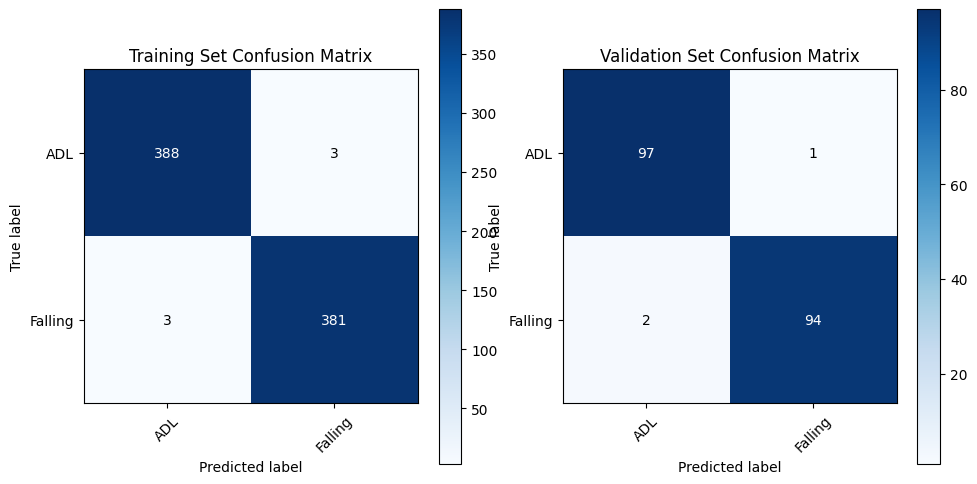

In [ ]:
best_C = 0.01
train_score, val_score = SVM_Linear_Kernel(X_train, y_train, X_val, y_val, best_C, True)

Hàm SVM dùng Gaussian/RBF kernel với tham số C và si (sử dụng phương pháp đánh giá Hold-out)

In [ ]:
def SVM_RBF_Kernel(X_train, y_train, X_val, y_val, C, gamma, draw_confusion_matrix=False):
    kernel_svm = SVC(C=C, gamma=gamma)

    # Huấn luyện mô hình
    kernel_svm.fit(X_train, y_train)

    # Dự đoán
    y_pred_train = kernel_svm.predict(X_train)
    y_pred_val = kernel_svm.predict(X_val)

    # Báo cáo kết quả
    label_names = ['ADL', 'Falling']
    train_report = classification_report(y_train, y_pred_train, target_names=label_names, output_dict=True, zero_division=0)
    val_report = classification_report(y_val, y_pred_val, target_names=label_names, output_dict=True, zero_division=0)

    if draw_confusion_matrix:
        # In báo cáo
        print('Training set report')
        print(classification_report(y_train, y_pred_train, target_names=label_names))
        print('Validation set report')
        print(classification_report(y_val, y_pred_val, target_names=label_names))

        # Vẽ ma trận nhầm lẫn
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plot_confusion_matrix(y_train, y_pred_train, label_names, title='Training Set Confusion Matrix')
        plt.subplot(1, 2, 2)
        plot_confusion_matrix(y_val, y_pred_val, label_names, title='Validation Set Confusion Matrix')
        plt.tight_layout()

    return train_report, val_report


Khảo sát mô hình với tham số C,  và RBF kernel (sử dụng kỹ thuật hold-out, phương pháp đánh giá recall)

Khảo sát mô hình với tham số C,  và RBF kernel (sử dụng kỹ thuật hold-out, phương pháp đánh giá f1-score)

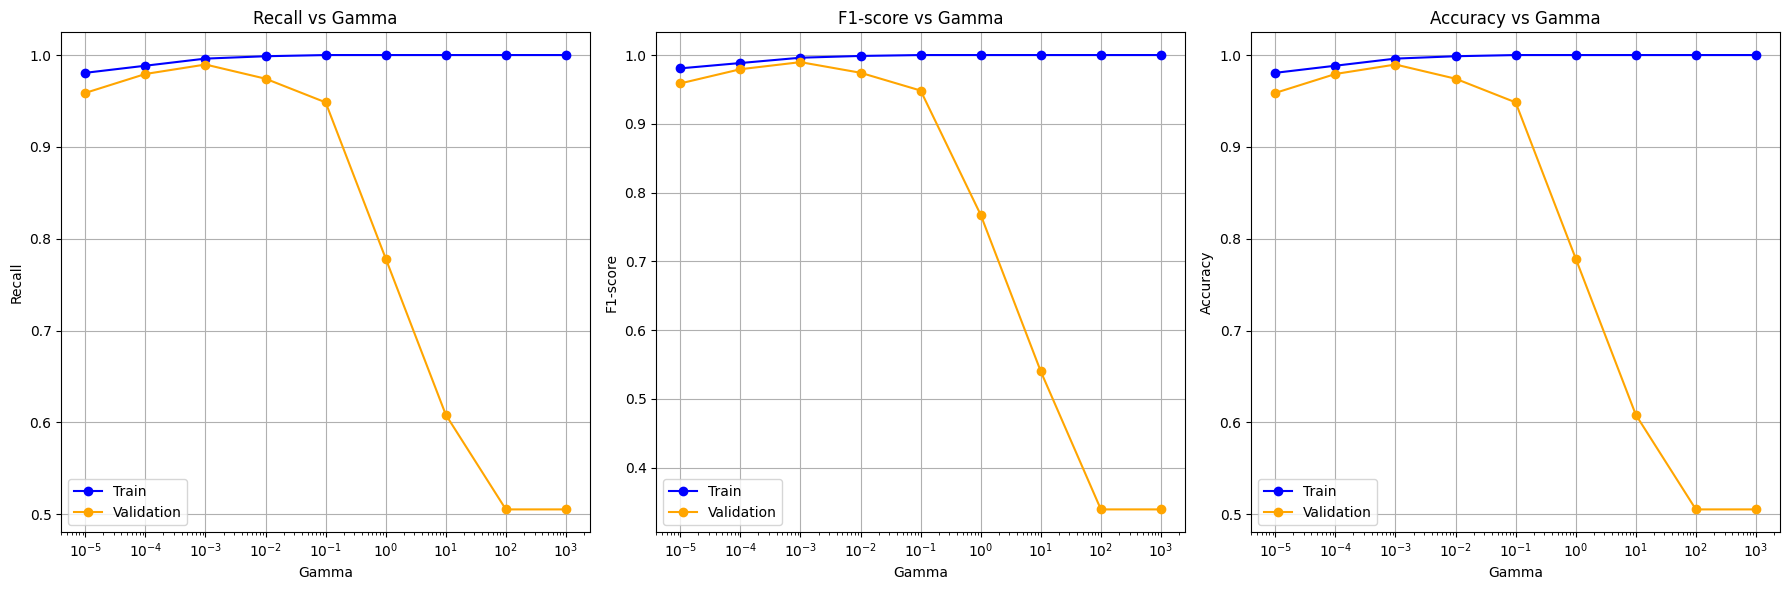

Best C and gamma on validation set with best recall:
C: 10
Gamma: 0.001
Best C and gamma on validation set with best f1-score:
C: 10
Gamma: 0.001


In [ ]:
# Các giá trị thử nghiệm cho tham số C và gamma
param_range_C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_range_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_report_dict = {}
val_report_dict = {}
best_val_C_recall = None
best_val_gamma_recall = None
best_val_recall = -1
best_val_C_f1 = None
best_val_gamma_f1 = None
best_val_f1_score = -1

for i, C in enumerate(param_range_C):
    for j, gamma in enumerate(param_range_gamma):
        train_report, val_report = SVM_RBF_Kernel(X_train, y_train, X_val, y_val, C, gamma)
        train_report_dict[(C, gamma)] = train_report
        val_report_dict[(C, gamma)] = val_report

        recall = val_report['weighted avg']['recall']
        if recall > best_val_recall:
            best_val_recall = recall
            best_val_C_recall = C
            best_val_gamma_recall = gamma

        f1_score = val_report['weighted avg']['f1-score']
        if f1_score > best_val_f1_score:
            best_val_f1_score = f1_score
            best_val_C_f1 = C
            best_val_gamma_f1 = gamma

# Mảng để lưu giá trị recall, f1-score và accuracy
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []
train_accuracies = []
val_accuracies = []

# Duyệt qua các giá trị gamma trong param_range_gamma cho giá trị C tốt nhất (best_val_C_recall)
for gamma in param_range_gamma:
    train_recalls.append(train_report_dict[(best_val_C_recall, gamma)]['weighted avg']['recall'])
    val_recalls.append(val_report_dict[(best_val_C_recall, gamma)]['weighted avg']['recall'])
    train_accuracies.append(train_report_dict[(best_val_C_recall, gamma)]['accuracy'])
    val_accuracies.append(val_report_dict[(best_val_C_recall, gamma)]['accuracy'])
    train_f1_scores.append(train_report_dict[(best_val_C_f1, gamma)]['weighted avg']['f1-score'])
    val_f1_scores.append(val_report_dict[(best_val_C_f1, gamma)]['weighted avg']['f1-score'])



# Vẽ đồ thị recall, f1-score và accuracy theo giá trị gamma trên ba cột
plt.figure(figsize=(18, 6))

# Plot recall
plt.subplot(1, 3, 1)
plt.plot(param_range_gamma, train_recalls, marker='o', color='blue', label='Train')
plt.plot(param_range_gamma, val_recalls, marker='o', color='orange', label='Validation')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Recall')
plt.title('Recall vs Gamma')
plt.legend()
plt.grid(True)

# Plot f1-score
plt.subplot(1, 3, 2)
plt.plot(param_range_gamma, train_f1_scores, marker='o', color='blue', label='Train')
plt.plot(param_range_gamma, val_f1_scores, marker='o', color='orange', label='Validation')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('F1-score')
plt.title('F1-score vs Gamma')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(param_range_gamma, train_accuracies, marker='o', color='blue', label='Train')
plt.plot(param_range_gamma, val_accuracies, marker='o', color='orange', label='Validation')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Best C and gamma on validation set with best recall:")
print("C:", best_val_C_recall)
print("Gamma:", best_val_gamma_recall)

print("Best C and gamma on validation set with best f1-score:")
print("C:", best_val_C_f1)
print("Gamma:", best_val_gamma_f1)

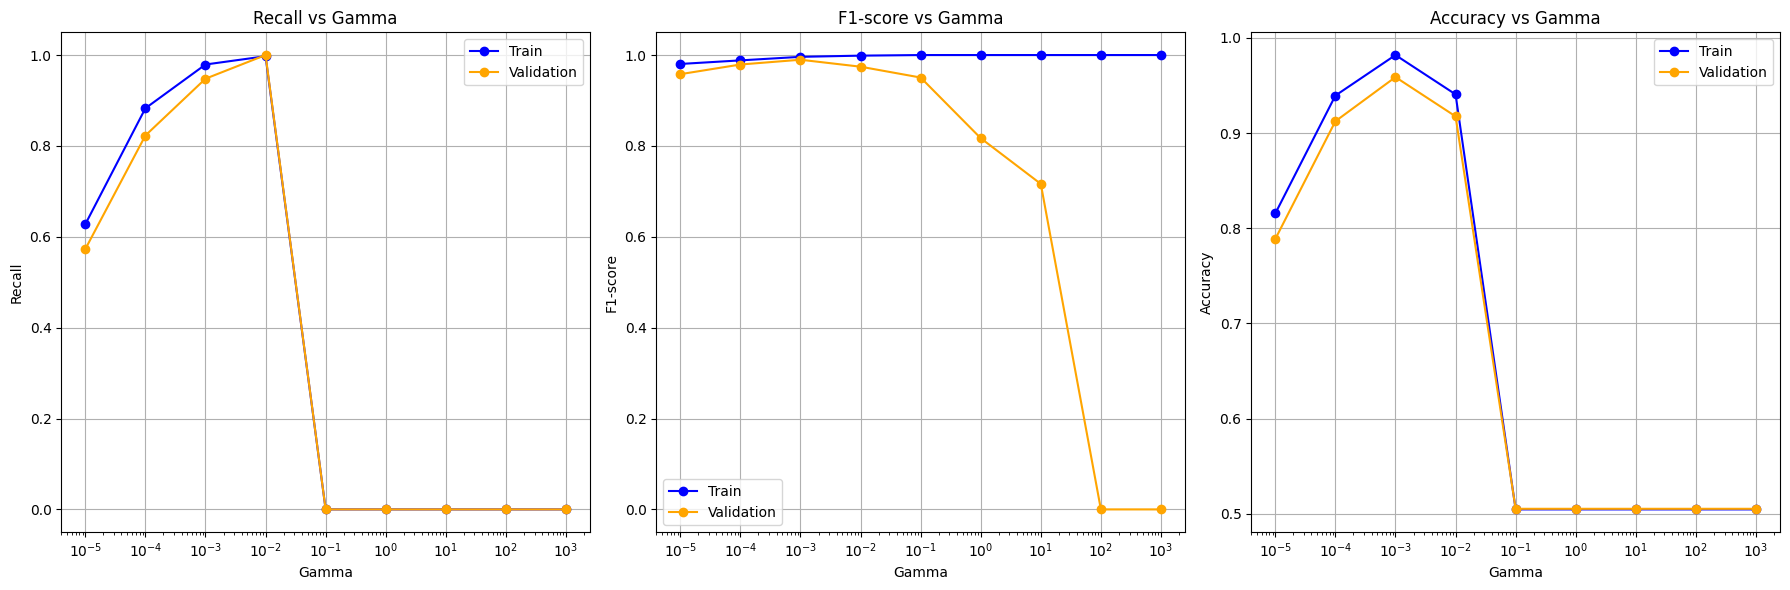

Best C and gamma on validation set with best recall:
C: 0.01
Gamma: 0.01
Best C and gamma on validation set with best f1-score:
C: 10
Gamma: 0.001


In [ ]:
# Các giá trị thử nghiệm cho tham số C và gamma
param_range_C = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
param_range_gamma = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

train_report_dict = {}
val_report_dict = {}
best_val_C_recall = None
best_val_gamma_recall = None
best_val_recall = -1
best_val_C_f1 = None
best_val_gamma_f1 = None
best_val_f1_score = -1

for i, C in enumerate(param_range_C):
    for j, gamma in enumerate(param_range_gamma):
        train_report, val_report = SVM_RBF_Kernel(X_train, y_train, X_val, y_val, C, gamma)
        train_report_dict[(C, gamma)] = train_report
        val_report_dict[(C, gamma)] = val_report

        recall = val_report['Falling']['recall']
        if recall > best_val_recall:
            best_val_recall = recall
            best_val_C_recall = C
            best_val_gamma_recall = gamma

        f1_score = val_report['Falling']['f1-score']
        if f1_score > best_val_f1_score:
            best_val_f1_score = f1_score
            best_val_C_f1 = C
            best_val_gamma_f1 = gamma

# Mảng để lưu giá trị recall, f1-score và accuracy
train_recalls = []
val_recalls = []
train_f1_scores = []
val_f1_scores = []
train_accuracies = []
val_accuracies = []

# Duyệt qua các giá trị gamma trong param_range_gamma cho giá trị C tốt nhất (best_val_C_recall)
for gamma in param_range_gamma:
    train_recalls.append(train_report_dict[(best_val_C_recall, gamma)]['Falling']['recall'])
    val_recalls.append(val_report_dict[(best_val_C_recall, gamma)]['Falling']['recall'])
    train_accuracies.append(train_report_dict[(best_val_C_recall, gamma)]['accuracy'])
    val_accuracies.append(val_report_dict[(best_val_C_recall, gamma)]['accuracy'])
    train_f1_scores.append(train_report_dict[(best_val_C_f1, gamma)]['Falling']['f1-score'])
    val_f1_scores.append(val_report_dict[(best_val_C_f1, gamma)]['Falling']['f1-score'])



# Vẽ đồ thị recall, f1-score và accuracy theo giá trị gamma trên ba cột
plt.figure(figsize=(18, 6))

# Plot recall
plt.subplot(1, 3, 1)
plt.plot(param_range_gamma, train_recalls, marker='o', color='blue', label='Train')
plt.plot(param_range_gamma, val_recalls, marker='o', color='orange', label='Validation')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Recall')
plt.title('Recall vs Gamma')
plt.legend()
plt.grid(True)

# Plot f1-score
plt.subplot(1, 3, 2)
plt.plot(param_range_gamma, train_f1_scores, marker='o', color='blue', label='Train')
plt.plot(param_range_gamma, val_f1_scores, marker='o', color='orange', label='Validation')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('F1-score')
plt.title('F1-score vs Gamma')
plt.legend()
plt.grid(True)

# Plot accuracy
plt.subplot(1, 3, 3)
plt.plot(param_range_gamma, train_accuracies, marker='o', color='blue', label='Train')
plt.plot(param_range_gamma, val_accuracies, marker='o', color='orange', label='Validation')
plt.xscale('log')
plt.xlabel('Gamma')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Gamma')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Best C and gamma on validation set with best recall:")
print("C:", best_val_C_recall)
print("Gamma:", best_val_gamma_recall)

print("Best C and gamma on validation set with best f1-score:")
print("C:", best_val_C_f1)
print("Gamma:", best_val_gamma_f1)

Training set report
              precision    recall  f1-score   support

         ADL       0.99      1.00      1.00       391
     Falling       1.00      0.99      1.00       384

    accuracy                           1.00       775
   macro avg       1.00      1.00      1.00       775
weighted avg       1.00      1.00      1.00       775

Validation set report
              precision    recall  f1-score   support

         ADL       1.00      0.98      0.99        98
     Falling       0.98      1.00      0.99        96

    accuracy                           0.99       194
   macro avg       0.99      0.99      0.99       194
weighted avg       0.99      0.99      0.99       194



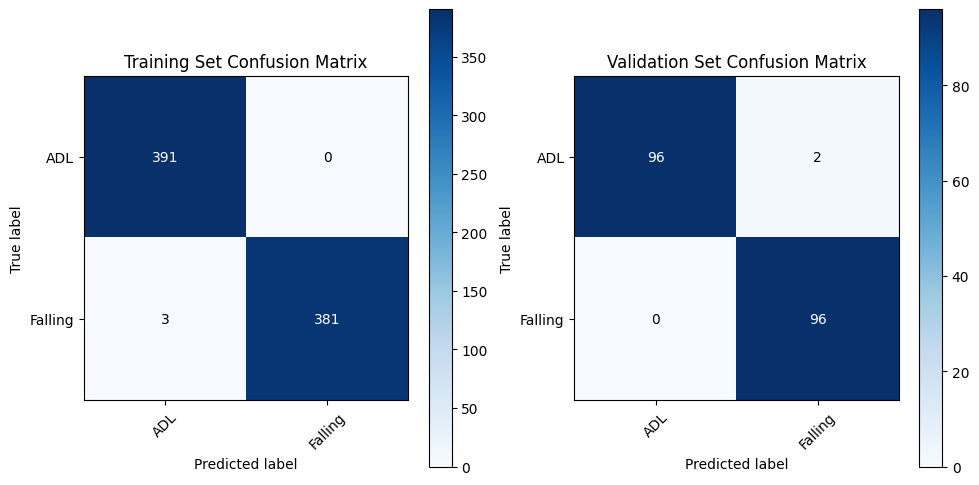

In [ ]:
best_C_RBF = 10
best_gamma_RBF = 0.001
train_score, val_score= SVM_RBF_Kernel(X_train, y_train, X_val, y_val, best_C_RBF, best_gamma_RBF, True)

Sử dụng k-fold validation kết hợp GridSearchCV khảo sát bộ tham số

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

Hàm train model --> truyền vào X_train_val, y_train_val và trả về best_model

In [ ]:
def train_and_evaluate(X_train_val, y_train_val):
    # Define the pipeline with StandardScaler and SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),  # Standardize the data
        ('clf', SVC())  # SVM classifier
    ])

    # Define the parameters for grid search
    tuned_parameters = [
        {'clf__kernel': ['rbf'], 'clf__gamma': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
         'clf__C': [0.001, 0.01, 0.1, 10, 25, 50, 100, 200, 500, 1000]},
        {'clf__kernel': ['linear'], 'clf__C': [0.001, 0.01, 0.1, 10, 25, 50, 100, 200, 500, 1000]}
    ]

    # Perform grid search with cross-validation
    grid_search = GridSearchCV(estimator=pipeline, param_grid=tuned_parameters, cv=5, scoring='f1', verbose=3)
    grid_search.fit(X_train_val, y_train_val)

    # Get the best hyperparameters and the corresponding accuracy
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Get the best model
    best_model = grid_search.best_estimator_

    return best_model, best_params, best_score

Train model và xuất bộ tham số

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf;, score=0.000 total time=   0.2s
[CV 2/5] END clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf;, score=0.000 total time=   0.1s
[CV 3/5] END clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf;, score=0.000 total time=   0.1s
[CV 4/5] END clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf;, score=0.000 total time=   0.1s
[CV 5/5] END clf__C=0.001, clf__gamma=1e-05, clf__kernel=rbf;, score=0.000 total time=   0.1s
[CV 1/5] END clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf;, score=0.000 total time=   0.1s
[CV 2/5] END clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf;, score=0.000 total time=   0.1s
[CV 3/5] END clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf;, score=0.000 total time=   0.1s
[CV 4/5] END clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf;, score=0.000 total time=   0.1s
[CV 5/5] END clf__C=0.001, clf__gamma=0.0001, clf__kernel=rbf;, score=0.000 total time=

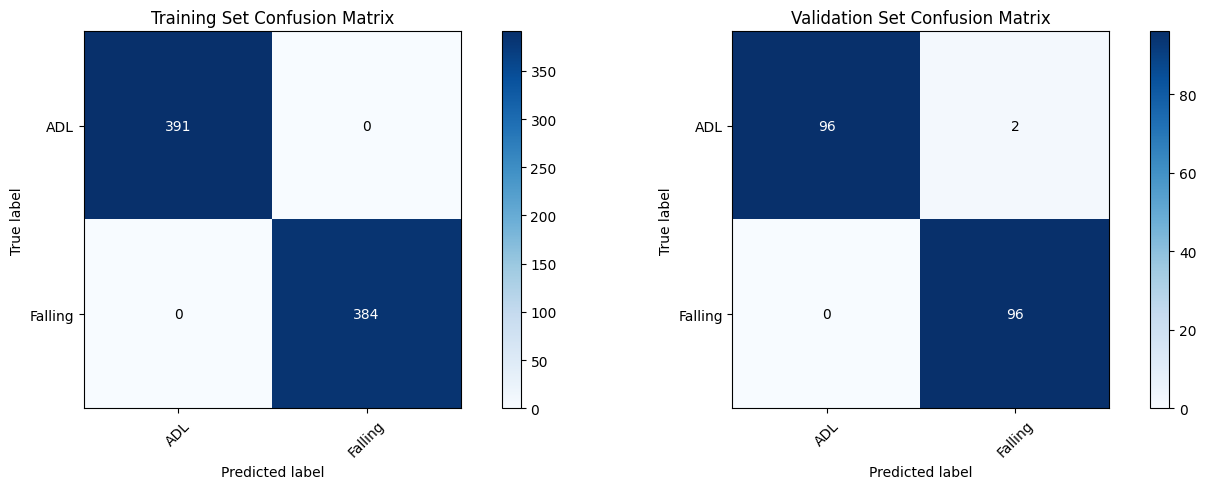

In [ ]:
best_model, best_params, best_score = train_and_evaluate(X_train, y_train)

print("\nBest model: ", best_model)
print("\nBest Hyperparameters:", best_params)
print("Best Accuracy:", best_score)

y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_val)

# Plotting
plt.figure(figsize=(15, 5))
label_names = ['ADL', 'Falling']
plt.subplot(1, 2, 1)
plot_confusion_matrix(y_train, y_train_pred, label_names, title='Training Set Confusion Matrix')
plt.subplot(1, 2, 2)
plot_confusion_matrix(y_val, y_test_pred, label_names, title='Validation Set Confusion Matrix')

Lưu best_model thành file joblib (dùng cho hệ thống nhúng)

In [ ]:
from joblib import dump, load

# Lưu best_model thành một file
dump(best_model, '/content/drive/MyDrive/FallDetectionAI/new_model.joblib')

['/content/drive/MyDrive/FallDetectionAI/new_model.joblib']

Lấy model từ file joblib

In [ ]:
model = load('/content/drive/MyDrive/FallDetectionAI/new_model.joblib')
print(model)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(C=25, gamma=0.1))])


Lưu best_model thành file pkl

In [ ]:
import pickle

In [ ]:
path = '/content/drive/MyDrive/FallDetectionAI/new_model.pkl'

with open(path, 'wb') as file:
    pickle.dump(best_model, file)

Lấy model file pkl

In [ ]:
path = '/content/drive/MyDrive/FallDetectionAI/new_model.pkl'

with open(path, 'rb') as file:
    model = pickle.load(file)
    print(model)

Pipeline(steps=[('scaler', StandardScaler()), ('clf', SVC(C=25, gamma=0.1))])
